In [1]:
import pandas as pd
import numpy as np
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
from sklearn.decomposition import NMF
import warnings
warnings.filterwarnings("ignore")
from sklearn.mixture import GaussianMixture
import os
import ot
import pickle
import argparse
import Levenshtein
import itertools
from helper_functions import *
##### input args
PROJECT = "gs-mrd"
release_version = "09122024_297_samples"
merge_version = "20240914"

##### configurations/paths
path_to_main_src = "/media/hieunguyen/HNSD01/src/gs-mrd"
path_to_merge_samples = f"{path_to_main_src}/all_samples/{merge_version}"

path_to_save_output = os.path.join(path_to_main_src, "output")
path_to_02_output = os.path.join(path_to_save_output, "02_output")

path_to_model_files = f"{path_to_02_output}/model_files/{release_version}"
path_to_save_features = f"{path_to_02_output}/model_files/{release_version}/features"

os.system(f"mkdir -p {path_to_save_features}")
os.system(f"mkdir -p {path_to_02_output}")

#####----------------------------------------------------------------------#####
##### PREPARE METADATA
#####----------------------------------------------------------------------#####
metadata = pd.read_csv("/media/hieunguyen/HNSD01/src/gs-mrd/model_files/10062024/release_metadata.csv")

general_metadata = pd.read_excel("All Samples GW_MRD_010924.modified.xlsx", index_col = [0])

metadata["Cancer"] = metadata["SampleID"].apply(lambda x: general_metadata[general_metadata["SampleID"] == x.split("-")[1]].Cancer.unique()[0])
metadata["True label"] = metadata["SampleID"].apply(lambda x: general_metadata[general_metadata["SampleID"] == x.split("-")[1]]["True label"].unique()[0])
metadata["SampleID2"] = metadata["SampleID"].apply(lambda x: x.split("-")[1])
motif_order = pd.read_csv("motif_order.csv").motif_order.to_list()
metadata297 = pd.read_csv("train_test_split_297_samples.csv")
metadata["Set"] = metadata["SampleID2"].apply(
    lambda x: metadata297[metadata297["SampleID"] == x]["Set"].unique()[0] if x in metadata297["SampleID"].to_list() else "validation"
    )
metadata = metadata[metadata["True label"] != "?"]

In [2]:
#####----------------------------------------------------------------------#####
##### PREPARE FEATURES
#####----------------------------------------------------------------------#####
samplelist = dict()
train_samplelist = dict()
test_samplelist = dict()

all_train_samples = []
all_test_samples = []
for label in metadata.Cancer.unique():
    samplelist[label] = metadata[metadata["Cancer"] == label]["SampleID"].to_list()
    train_samplelist[label] = metadata[(metadata["Set"] == "train") & (metadata["Cancer"] == label)]["SampleID"].to_list()
    test_samplelist[label] = metadata[(metadata["Set"] == "validation") & (metadata["Cancer"] == label)]["SampleID"].to_list()
    all_train_samples = all_train_samples + train_samplelist[label]
    all_test_samples = all_test_samples + test_samplelist[label]

full_featuredf = dict()
train_featuredf = dict()
test_featuredf = dict()
for input_feature in ["EM", "FLEN", "NUCLEOSOME", "IchorCNA"]:
    tmpdf = pd.read_csv(f"{path_to_merge_samples}/{input_feature}_features.csv")
    tmpdf = tmpdf[tmpdf["SampleID"].isin(metadata.SampleID.unique())]
    if input_feature == "EM":
        full_featuredf[input_feature] = tmpdf[["SampleID"] + motif_order].copy()
    else:
        full_featuredf[input_feature] = tmpdf.copy()
        
    assert full_featuredf[input_feature].shape[0] == metadata.shape[0]
    full_featuredf[input_feature].to_csv(f"{path_to_save_features}/{input_feature}_full_features.csv", index = False)
    train_featuredf[input_feature] = tmpdf[tmpdf["SampleID"].isin(all_train_samples)]
    test_featuredf[input_feature] = tmpdf[tmpdf["SampleID"].isin(all_test_samples)]
    train_featuredf[input_feature].to_csv(f"{path_to_save_features}/{input_feature}_train_features.csv", index = False)
    test_featuredf[input_feature].to_csv(f"{path_to_save_features}/{input_feature}_test_features.csv", index = False)
    
##### distance matrix based on edit distance of End motif 4bp
nucleotides = ['A', 'C', 'G', 'T']
motifs = [''.join(p) for p in itertools.product(nucleotides, repeat=4)]

# Initialize an empty distance matrix
distance_matrix = pd.DataFrame(index=motifs, columns=motifs)

# Compute the Levenshtein distance between each pair of 4-mer motifs
for motif1 in motifs:
    for motif2 in motifs:
        distance_matrix.loc[motif1, motif2] = Levenshtein.distance(motif1, motif2)

# Convert the distance matrix to integer type
M_EM = distance_matrix.to_numpy().copy()
M_EM /= M_EM.max() * 0.1

# Train the NMF and OT distance barycenter

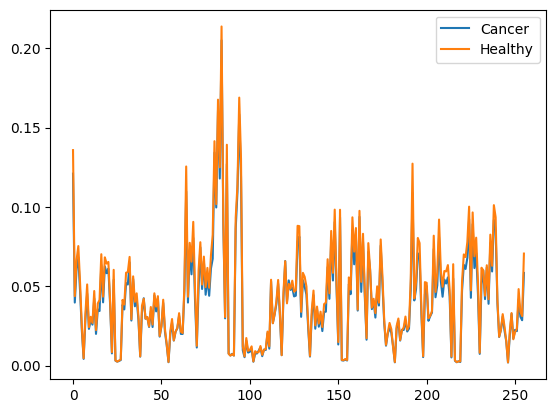

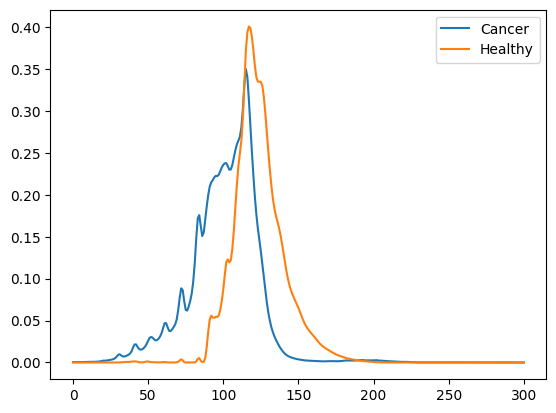

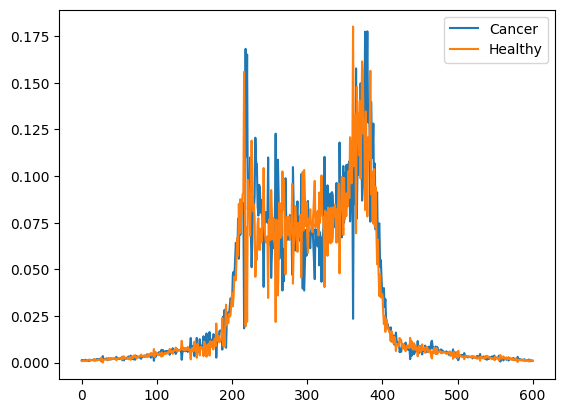

In [3]:
train_features = dict() 

for input_feature in ["EM", "FLEN", "NUCLEOSOME"]:
    ##### generate average FEATURE in all control samples in this batch
    inputdf = train_featuredf[input_feature].copy().set_index("SampleID").T
    inputdf["Healthy"] = inputdf[train_samplelist["Healthy"]].mean(axis = 1)
    inputdf[["Healthy"]].to_csv(f"{path_to_model_files}/Healthy_reference_{input_feature}.csv")
    inputdf = inputdf.drop("Healthy", axis = 1)
    
    ##### calculate OT barycenters
    if input_feature == "EM":
        baryl2 = calculate_barycenter(inputdf = train_featuredf[input_feature].set_index("SampleID").T,
                                      samplelist = train_samplelist, 
                                      n = inputdf.shape[0], show_plot=False, M = M_EM)
    else: 
        baryl2 = calculate_barycenter(inputdf = train_featuredf[input_feature].set_index("SampleID").T,
                                      samplelist = train_samplelist, 
                                      n = inputdf.shape[0], show_plot=False, M = None)
    pd.DataFrame(data = baryl2, columns = ["baryl2"]).to_csv(f"{path_to_model_files}/Healthy_OT_{input_feature}_baryl2.csv", index = False)
    
    ##### NMF models
    X = train_featuredf[input_feature].set_index("SampleID")
    model = NMF(n_components=2, init='random', random_state=0, solver = "mu")
    W = model.fit_transform(X.to_numpy())
    H = model.components_
    nmfdf = pd.DataFrame(data = W, columns = ["V1", "V2"])
    nmfdf["SampleID"] = list(X.index)
    nmfdf["V1_scale"] = nmfdf[["V1", "V2"]].apply(lambda x: x[0]/sum(x), axis = 1)
    nmfdf["V2_scale"] = nmfdf[["V1", "V2"]].apply(lambda x: x[1]/sum(x), axis = 1)
    nmfdf = nmfdf.merge(metadata, right_on = "SampleID", left_on = "SampleID")
    sns.lineplot(H[0, ], label = "Cancer")
    sns.lineplot(H[1, ], label = "Healthy")
    plt.legend()
    plt.show()

    signal1 = [i for i,j in enumerate(H[0, ]) if j == np.max(H[0, ])][0]
    signal2 = [i for i,j in enumerate(H[1, ]) if j == np.max(H[1, ])][0]

    if (signal1 < signal2):
        nmf_signal_cancer = 1
    else:
        nmf_signal_cancer = 2
    pd.DataFrame(data = [nmf_signal_cancer], columns = ["nmf_signal_cancer"]).to_csv(f"{path_to_model_files}/NMF_{input_feature}_cancer_signal.csv")
    filename = os.path.join(path_to_model_files, f'NMF_{input_feature}.sav')
    pickle.dump(model, open(filename, 'wb'))
    
    tmpdf = nmfdf[["SampleID", f"V{nmf_signal_cancer}_scale"]].copy()
    tmpdf.columns = ["SampleID", f"NMF_{input_feature}_{nmf_signal_cancer}"]
    train_features[f"NMF_{input_feature}_{nmf_signal_cancer}"] = tmpdf.copy()


    

# Transform the training data and determine the cut-off, cut-off = maximum value in healthy samples.

In [4]:
#####--------------------------------------------------------------#####
##### Generate cut-off for this release
#####--------------------------------------------------------------#####

##### absolute difference between a sample and the reference
# prepare references
ref = dict()

em_ref = pd.read_csv(f"{path_to_model_files}/Healthy_reference_EM.csv")
em_ref.columns = ["motif", "Healthy"]
ref["EM"] = em_ref.copy()

flen_ref = pd.read_csv(f"{path_to_model_files}/Healthy_reference_FLEN.csv")
flen_ref.columns = ["FLEN", "Healthy"]
ref["FLEN"] = flen_ref.copy()

nuc_ref = pd.read_csv(f"{path_to_model_files}/Healthy_reference_NUCLEOSOME.csv")
nuc_ref.columns = ["Nucleosome", "Healthy"]
ref["NUCLEOSOME"] = nuc_ref.copy()

all_samples = train_featuredf["FLEN"].SampleID.unique()

# add score EM, FLEN, NUCLEOSOME to train_features
for f in ["EM", "FLEN", "NUCLEOSOME"]:
    inputdf = train_featuredf[f].set_index("SampleID").T.copy()
    inputdf["Healthy"] = ref[f]["Healthy"].values
    for sampleid in all_samples:
        inputdf[sampleid] = abs(inputdf[sampleid] - inputdf["Healthy"])
    input_scoredf = inputdf.drop("Healthy", axis = 1).sum().reset_index()
    input_scoredf.columns = ["SampleID", f"{f}_score"]
    input_scoredf = input_scoredf.merge(metadata, right_on = "SampleID", left_on = "SampleID")
    train_features[f"{f}_score"] = input_scoredf

f = "EM"
inputdf = train_featuredf[f].set_index("SampleID").T

em_shannondf = pd.DataFrame(data = inputdf.columns, columns = ["SampleID"])
def calculate_em_shannon(x, inputdf):
    tmpdf = inputdf[x].values
    shannon = -np.sum([item * np.log2(item) for item in tmpdf])/256
    return(shannon)
em_shannondf["EM_shannon"] = em_shannondf["SampleID"].apply(lambda x: calculate_em_shannon(x, inputdf))
em_shannondf = em_shannondf.merge(metadata, right_on = "SampleID", left_on = "SampleID")
train_features["EM_shannon"] = em_shannondf

##### OT distance
for f in ["EM", "FLEN", "NUCLEOSOME"]:
    barycenter = pd.read_csv(f"{path_to_model_files}/Healthy_OT_{f}_baryl2.csv")
    bary_l2 = barycenter.baryl2.to_numpy()
    ot_scoredf = pd.DataFrame(data = all_samples, columns = ["SampleID"])
    ot_scoredf[f"OT_{f}"] = ot_scoredf["SampleID"].apply(lambda x: 
        calculate_ot_distance_to_healthy_nuc(x, 
                                             bary_l2, 
                                             train_featuredf[f].set_index("SampleID").T, 
                                             n = train_featuredf[f].shape[1] - 1))
    ot_scoredf = ot_scoredf.merge(metadata, right_on = "SampleID", left_on = "SampleID")
    train_features[f"OT_{f}"] = ot_scoredf
    
train_features["ichorCNA"] = train_featuredf["IchorCNA"]
outputdf = pd.DataFrame(data = metadata["SampleID"].to_list(), columns = ["SampleID"])
for feat in train_features.keys():
    tmpdf = train_features[feat][["SampleID", feat]]
    tmpdf.columns = ["SampleID", feat]
    outputdf = outputdf.merge(tmpdf, right_on = "SampleID", left_on = "SampleID")

outputdf = outputdf.merge(metadata, right_on = "SampleID", left_on = "SampleID")

excluded_samples = ["20-KABH63"]
cutoffdf = outputdf[outputdf["SampleID"].isin([item for item in samplelist["Healthy"] if item not in excluded_samples])][ ["SampleID"] + list(train_features.keys())].set_index("SampleID").max().reset_index()
cutoffdf.columns = ["feature", "cutoff"]
cutoffdf.to_csv(f"{path_to_model_files}/cutoff.csv", index = False)

# Transform the test data

In [5]:
test_features = dict()

##### absolute difference between a sample and the reference
# prepare references
ref = dict()

em_ref = pd.read_csv(f"{path_to_model_files}/Healthy_reference_EM.csv")
em_ref.columns = ["motif", "Healthy"]
ref["EM"] = em_ref.copy()

flen_ref = pd.read_csv(f"{path_to_model_files}/Healthy_reference_FLEN.csv")
flen_ref.columns = ["FLEN", "Healthy"]
ref["FLEN"] = flen_ref.copy()

nuc_ref = pd.read_csv(f"{path_to_model_files}/Healthy_reference_NUCLEOSOME.csv")
nuc_ref.columns = ["Nucleosome", "Healthy"]
ref["NUCLEOSOME"] = nuc_ref.copy()

all_samples = test_featuredf["FLEN"].SampleID.unique()

# add score EM, FLEN, NUCLEOSOME to test_features
for f in ["EM", "FLEN", "NUCLEOSOME"]:
    inputdf = test_featuredf[f].set_index("SampleID").T.copy()
    inputdf["Healthy"] = ref[f]["Healthy"].values
    for sampleid in all_samples:
        inputdf[sampleid] = abs(inputdf[sampleid] - inputdf["Healthy"])
    input_scoredf = inputdf.drop("Healthy", axis = 1).sum().reset_index()
    input_scoredf.columns = ["SampleID", f"{f}_score"]
    input_scoredf = input_scoredf.merge(metadata, right_on = "SampleID", left_on = "SampleID")
    test_features[f"{f}_score"] = input_scoredf

f = "EM"
inputdf = test_featuredf[f].set_index("SampleID").T

em_shannondf = pd.DataFrame(data = inputdf.columns, columns = ["SampleID"])
def calculate_em_shannon(x, inputdf):
    tmpdf = inputdf[x].values
    shannon = -np.sum([item * np.log2(item) for item in tmpdf])/256
    return(shannon)
em_shannondf["EM_shannon"] = em_shannondf["SampleID"].apply(lambda x: calculate_em_shannon(x, inputdf))
em_shannondf = em_shannondf.merge(metadata, right_on = "SampleID", left_on = "SampleID")
test_features["EM_shannon"] = em_shannondf
##### OT distance
for f in ["EM", "FLEN", "NUCLEOSOME"]:
    barycenter = pd.read_csv(f"{path_to_model_files}/Healthy_OT_{f}_baryl2.csv")
    bary_l2 = barycenter.baryl2.to_numpy()
    ot_scoredf = pd.DataFrame(data = all_samples, columns = ["SampleID"])
    ot_scoredf[f"OT_{f}"] = ot_scoredf["SampleID"].apply(lambda x: 
        calculate_ot_distance_to_healthy_nuc(x, 
                                             bary_l2, 
                                             test_featuredf[f].set_index("SampleID").T, 
                                             n = test_featuredf[f].shape[1] - 1))
    ot_scoredf = ot_scoredf.merge(metadata, right_on = "SampleID", left_on = "SampleID")
    test_features[f"OT_{f}"] = ot_scoredf
    
test_features["ichorCNA"] = test_featuredf["IchorCNA"]

for input_feature in ["EM", "FLEN", "NUCLEOSOME"]:
    filename = os.path.join(path_to_model_files, f'NMF_{input_feature}.sav')
    model = pickle.load(open(filename, 'rb'))
    X = test_featuredf[input_feature].set_index("SampleID")
    W = model.transform(X.to_numpy())
    H = model.components_
    nmf_signal_cancer = cutoffdf[cutoffdf["feature"].str.contains(input_feature)]["feature"].values[0].split("_")[2]
    nmfdf = pd.DataFrame(data = W, columns = ["V1", "V2"])
    nmfdf["SampleID"] = list(X.index)
    nmfdf["V1_scale"] = nmfdf[["V1", "V2"]].apply(lambda x: x[0]/sum(x), axis = 1)
    nmfdf["V2_scale"] = nmfdf[["V1", "V2"]].apply(lambda x: x[1]/sum(x), axis = 1)
    nmfdf = nmfdf.merge(metadata, right_on = "SampleID", left_on = "SampleID")
    tmpdf = nmfdf[["SampleID", f"V{nmf_signal_cancer}_scale"]].copy()
    tmpdf.columns = ["SampleID", f"NMF_{input_feature}_{nmf_signal_cancer}"]
    test_features[f"NMF_{input_feature}_{nmf_signal_cancer}"] = tmpdf.copy()
test_outputdf = pd.DataFrame(data = metadata["SampleID"].to_list(), columns = ["SampleID"])
for feat in test_features.keys():
    tmpdf = test_features[feat][["SampleID", feat]]
    tmpdf.columns = ["SampleID", feat]
    test_outputdf = test_outputdf.merge(tmpdf, right_on = "SampleID", left_on = "SampleID")


In [6]:
from itertools import combinations
test_outputdf = test_outputdf.merge(metadata, right_on = "SampleID", left_on = "SampleID")
all_features = test_features.keys()
for feat in all_features:
    c = cutoffdf[cutoffdf["feature"] == feat].cutoff.values[0]
    test_outputdf[f"prediction_{feat}"] = test_outputdf[feat].apply(
        lambda x: 1 if x > c else 0
    )
test_outputdf = test_outputdf[test_outputdf["True label"] != "?"]
test_outputdf["True_label"] = test_outputdf["True label"].apply(lambda x: 1 if x == "+" else 0)
# test_resdf = pd.DataFrame(data = all_features, columns = ["feature"])
# test_resdf["SEN"] = test_resdf["feature"].apply(
#     lambda x: test_outputdf[(test_outputdf[f"prediction_{x}"] == 1) & (test_outputdf["True_label"] == 1)].shape[0]/test_outputdf[test_outputdf["True_label"]== 1].shape[0]
# )
# test_resdf["SPEC"] = test_resdf["feature"].apply(
#     lambda x: test_outputdf[(test_outputdf[f"prediction_{x}"] == 0) & (test_outputdf["True_label"] == 0)].shape[0]/test_outputdf[test_outputdf["True_label"]== 0].shape[0]
# )



In [7]:

all_features = test_features.keys()
for feat in all_features:
    c = cutoffdf[cutoffdf["feature"] == feat].cutoff.values[0]
    outputdf[f"prediction_{feat}"] = outputdf[feat].apply(
        lambda x: 1 if x > c else 0
    )
outputdf = outputdf[outputdf["True label"] != "?"]
outputdf["True_label"] = outputdf["True label"].apply(lambda x: 1 if x == "+" else 0)
train_resdf = pd.DataFrame(data = all_features, columns = ["feature"])
train_resdf["SEN"] = train_resdf["feature"].apply(
    lambda x: outputdf[(outputdf[f"prediction_{x}"] == 1) & (outputdf["True_label"] == 1)].shape[0]/outputdf[outputdf["True_label"]== 1].shape[0]
)
train_resdf["SPEC"] = train_resdf["feature"].apply(
    lambda x: outputdf[(outputdf[f"prediction_{x}"] == 0) & (outputdf["True_label"] == 0)].shape[0]/outputdf[outputdf["True_label"]== 0].shape[0]
)


In [8]:
feature_combinations = []
for i in range(1, len(all_features) + 1):
    feature_combinations.extend(combinations(all_features, i))

combinedf = pd.DataFrame(data = [",".join(feature_combinations[i]) for i in range(len(feature_combinations))], columns = ["feature_combinations"])
def get_Sen_Spec_for_combi(combi, inputdf):
    input_feats = combi.split(",")
    tmpdf =  inputdf[["True_label"] + [f"prediction_{i}" for i in input_feats]]
    tmpdf["sum"] = tmpdf[[f"prediction_{i}" for i in input_feats]].sum(axis = 1)
    tmpdf["prediction"] = tmpdf["sum"].apply(lambda x: 1 if x != 0 else 0)
    sen = tmpdf[(tmpdf["prediction"] == 1) & (tmpdf["True_label"] == 1)].shape[0]/tmpdf[tmpdf["True_label"]== 1].shape[0]
    spec = tmpdf[(tmpdf["prediction"] == 0) & (tmpdf["True_label"] == 0)].shape[0]/tmpdf[tmpdf["True_label"]== 0].shape[0]
    return(sen, spec)

combinedf[["SEN_Train", "SPEC_Train"]] = combinedf["feature_combinations"].apply(lambda x: get_Sen_Spec_for_combi(x, outputdf)).apply(pd.Series)
combinedf[["SEN_Validation", "SPEC_Validation"]] = combinedf["feature_combinations"].apply(lambda x: get_Sen_Spec_for_combi(x, test_outputdf)).apply(pd.Series)


In [9]:
combinedf[combinedf["feature_combinations"] == "ichorCNA,NMF_FLEN_1"]

,feature_combinations,SEN_Train,SPEC_Train,SEN_Validation,SPEC_Validation
61,"ichorCNA,NMF_FLEN_1",0.543779,0.98,0.5,0.742857


In [10]:
combinedf[combinedf["feature_combinations"] == "FLEN_score"]

,feature_combinations,SEN_Train,SPEC_Train,SEN_Validation,SPEC_Validation
1,FLEN_score,0.364055,0.94,0.272727,0.685714


In [11]:
test_outputdf.to_csv(os.path.join(path_to_model_files, "testdf.csv"))
outputdf.to_csv(os.path.join(path_to_model_files, "traindf.csv"))
combinedf.to_csv(os.path.join(path_to_model_files, "combinedf.csv"))